<a href="https://colab.research.google.com/github/anaghab3/flower-vision/blob/main/Anagha_FlowerRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code modified from:
https://github.com/RockyXu66/Kaggle_Flowers_Classification_Keras

## **Flower Recognition Research**

In order to get a better understanding of working with classifying flowers, I have been working on building a simple neural network to classify flower images by types daisy, dandelion, rose, sunflower, and tulip.

We start off with accessing the dataset from my drive. 
For general access to the dataset, please access it from this link: 
[Dataset from Kaggle](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We enable the GPU in Google Colab.

In [2]:
!nvidia-smi

Fri Jun 10 18:25:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Here, we import some necessary libraries.

In [3]:
import os
import time
import zipfile
import cv2
import keras
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils

from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

import tensorflow_hub as hub
import tensorflow_datasets as tfds
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display
print('finished')

finished


In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.8.2
Hub version:  0.12.0
GPU is available


## Preprocessing the Data
Converting the data from files in GDrive to numpy arrays ready to feed into the net.

In [5]:
#unzip the directory from drive
zip_ref = zipfile.ZipFile('drive/My Drive/archive.zip', 'r')
zip_ref.extractall('unzipped_folder') # unzip directory
zip_ref.close()

In [6]:
# base_path = 'Dataset/flowers/'
base_path = 'unzipped_folder/flowers/'
# daisy, dandelion, rose, sunflower, tulip
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [7]:
base_path

'unzipped_folder/flowers/'

In [8]:
# putting all the flower file names in a list
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [9]:
# number of flower images per category
for i in range(5):
  print(len(fnames[i]))

764
1052
784
733
984


In [10]:
# showing how the filename can be converted to a numpy array representing the image file
daisies = fnames[0]
daisy1 = daisies[0]

read = cv2.imread(daisy1)
print(read)

[[[ 38  86  74]
  [ 38  86  74]
  [ 38  86  74]
  ...
  [  0  67  38]
  [  1  67  38]
  [  1  67  38]]

 [[ 39  87  75]
  [ 39  87  75]
  [ 39  87  75]
  ...
  [  0  67  38]
  [  1  67  38]
  [  1  67  38]]

 [[ 41  89  77]
  [ 40  88  76]
  [ 38  88  76]
  ...
  [  0  67  38]
  [  0  67  38]
  [  0  67  38]]

 ...

 [[ 17 102  82]
  [ 12  86  74]
  [ 27  93  68]
  ...
  [237 234 229]
  [235 232 227]
  [235 232 227]]

 [[ 12  94  76]
  [ 17  86  71]
  [ 66 121  96]
  ...
  [238 235 230]
  [237 234 229]
  [237 234 229]]

 [[ 13  93  80]
  [ 45 112  91]
  [127 174 148]
  ...
  [240 237 232]
  [239 236 231]
  [239 236 231]]]


In [11]:
# converting all the images in fnames containing the image paths to numpy arrays
images = []
for flower in fnames:
  one_category_images = []
  for image in flower:
    if cv2.imread(image) is not None:
      rgb_image = cv2.imread(image)
      one_category_images.append(rgb_image)
  images.append(one_category_images)

In [12]:
# finding the minimum shape of each file
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

134,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


In [13]:
# converting each image from BGR to RGB
def convertToRGB(img):
  return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

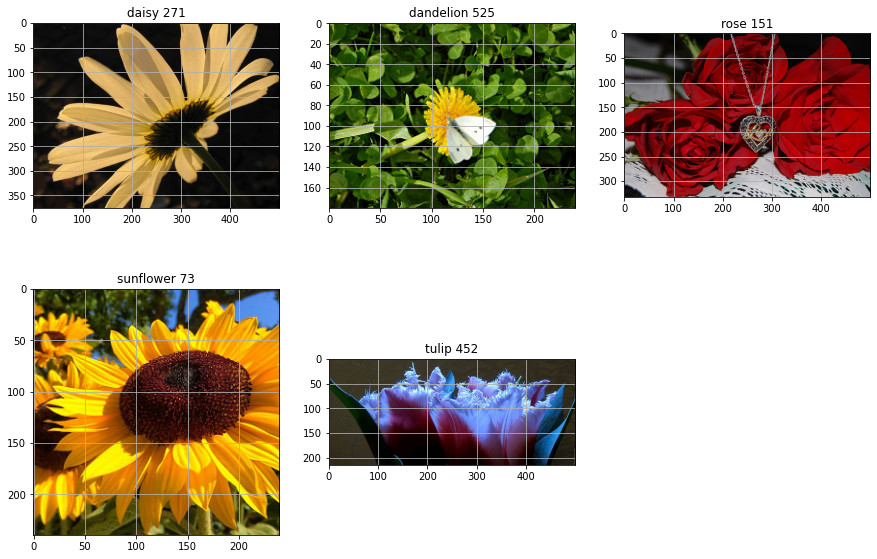

In [14]:
# printing 5 random pictures of flowers
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(convertToRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i] + ' ' + str(idx))
plt.show()

In [15]:
# Apply resize to all images
img_width, img_height = 224, 224
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

In [16]:
# spliting the images into training and testing sets
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

In [17]:
# seeing distribution of different flower types within training and testing sets
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[611, 841, 627, 586, 787]
sum of train images: 3452
[153, 211, 157, 147, 197]
sum of val_images: 865


In [18]:
# converting training images to easier to use format
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [19]:
# Converting labels to a categorical format
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

print(train_categories[4])
train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)
print(train_categories[4])

Before converting
train data: (3452, 224, 224, 3)
train labels: (3452,)
0

After converting
train data: (3452, 224, 224, 3)
train labels: (3452, 5)
0


In [20]:
# randomly shuffling the dataset
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [21]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (3400, 224, 224, 3)
shape of train labels: (3400, 5)
shape of val data: (860, 224, 224, 3)
shape of val labels: (860, 5)


In [22]:
# preprocessing the dataset for the vgg16
train_data = tf.keras.applications.vgg16.preprocess_input(train_data)
val_data = tf.keras.applications.vgg16.preprocess_input(val_data)

## Building the Model

We are using transfer learning to repurpose the VGG16 for our flower problem.

In [23]:
#importing the VGG16 model
vgg = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

In [24]:
vgg.trainable = False

In [25]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
# Adding a few dense layers to our neural network
inputs = keras.Input(shape = (224, 224, 3))
x = vgg(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1000)(x)
x = keras.layers.Dense(100)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [27]:
batch_size = 32
epochs1 = 10

In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

In [29]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1000)              513000    
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                             

In [31]:
train_labels_index = []
for label in train_labels:
  for i in range(5):
    if label[i] == 1.0:
      train_labels_index.append(i)

In [32]:
array = np.array(train_labels_index)

In [33]:
start = time.time()

model_scratch_info = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs1, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
106/106 - 54s - loss: 1.1921e-07 - accuracy: 0.7391 - val_loss: 1.1921e-07 - val_accuracy: 0.7672 - 54s/epoch - 504ms/step
Epoch 2/10
106/106 - 47s - loss: 1.1921e-07 - accuracy: 0.7358 - val_loss: 1.1921e-07 - val_accuracy: 0.7672 - 47s/epoch - 445ms/step
Epoch 3/10
106/106 - 45s - loss: 1.1921e-07 - accuracy: 0.7356 - val_loss: 1.1921e-07 - val_accuracy: 0.7672 - 45s/epoch - 421ms/step
Epoch 4/10
106/106 - 44s - loss: 1.1921e-07 - accuracy: 0.7382 - val_loss: 1.1921e-07 - val_accuracy: 0.7672 - 44s/epoch - 418ms/step
Epoch 5/10
106/106 - 44s - loss: 1.1921e-07 - accuracy: 0.7356 - val_loss: 1.1921e-07 - val_accuracy: 0.7672 - 44s/epoch - 418ms/step
Epoch 6/10
106/106 - 45s - loss: 1.1921e-07 - accuracy: 0.7400 - val_loss: 1.1921e-07 - val_accuracy: 0.7672 - 45s/epoch - 419ms/step
Epoch 7/10
106/106 - 46s - loss: 1.1921e-07 - accuracy: 0.7437 - val_loss: 1.1921e-07 - val_accuracy: 0.7672 - 46s/epoch - 430ms/step
Epoch 8/10
106/106 - 44s - loss: 1.1921e-07 - accuracy: 0.7388

In [34]:
results = model.evaluate(val_generator)
print('loss: ', results[0])
print('accuracy: ', results[1])

27/27 [==============================] - 4s 160ms/step - loss: 1.1921e-07 - accuracy: 0.7672
loss:  1.1920930376163597e-07
accuracy:  0.7672092318534851


[0.7391178607940674, 0.7357645630836487, 0.7355883121490479, 0.738235354423523, 0.7355882525444031, 0.7400001287460327, 0.7437057495117188, 0.7387647032737732, 0.735588014125824, 0.7362942099571228]


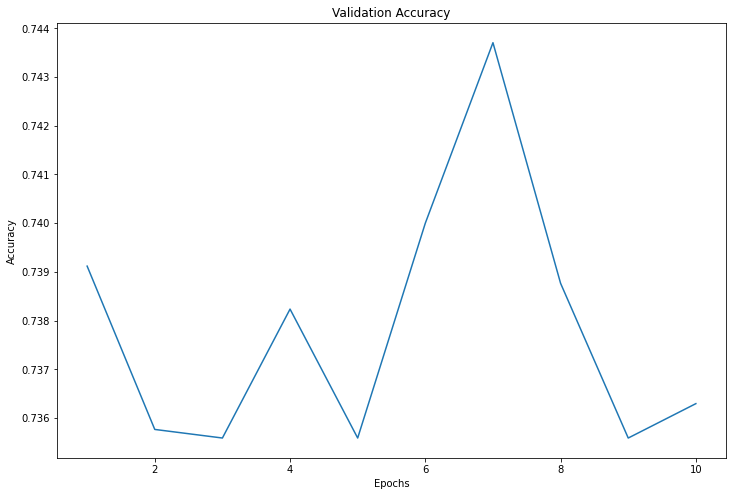

In [37]:
accuracy_val = model_scratch_info.history['accuracy']
print(loss_val)
epochs = [1,2,3,4,5,6,7,8,9,10]
plt.plot(epochs, loss_val)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

[1.1920930376163597e-07, 1.1920930376163597e-07, 1.1920930376163597e-07, 1.1920930376163597e-07, 1.1920930376163597e-07, 1.1920930376163597e-07, 1.1920930376163597e-07, 1.1920930376163597e-07, 1.1920930376163597e-07, 1.1920930376163597e-07]


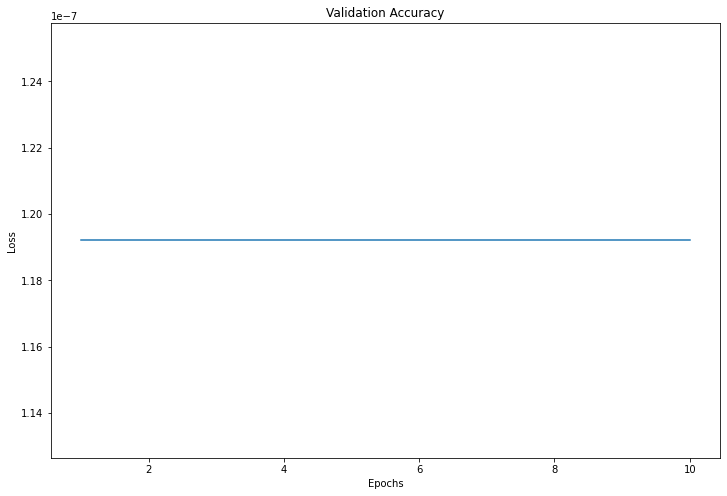

In [39]:
loss_val = model_scratch_info.history['loss']
print(loss_val)
epochs = [1,2,3,4,5,6,7,8,9,10]
plt.plot(epochs, loss_val)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [40]:
predictions = model.predict(val_generator)

In [41]:
predictions[:10]

array([[ 0.4370063 ],
       [-0.06131228],
       [ 0.46844262],
       [ 0.5395888 ],
       [ 0.38276708],
       [ 0.2784015 ],
       [ 0.24637067],
       [ 0.17548683],
       [-0.04361959],
       [ 0.32652098]], dtype=float32)

In [42]:
predictions_list = []
for prediction in predictions:
  for i in prediction:
    predictions_list.append(i)

In [44]:
predictions_array = np.array(predictions_list)

In [45]:
predictions_array.shape

(860,)

In [46]:
val_labels_index = []
for label in val_labels:
  for i in range(5):
    if label[i] == 1.0:
      val_labels_index.append(i)

In [47]:
array_ = np.array(val_labels_index)

In [48]:
array_.shape

(860,)

In [49]:
argmax_label = np.argmax(val_labels, axis = -1)

In [51]:
counter = 0
for predictions in predictions_array:
  print('Prediction was ', prediction, ' --> Actual was ', array_[counter])
  counter+=1

Prediction was  [0.14988774]  --> Actual was  3
Prediction was  [0.14988774]  --> Actual was  1
Prediction was  [0.14988774]  --> Actual was  1
Prediction was  [0.14988774]  --> Actual was  2
Prediction was  [0.14988774]  --> Actual was  0
Prediction was  [0.14988774]  --> Actual was  0
Prediction was  [0.14988774]  --> Actual was  1
Prediction was  [0.14988774]  --> Actual was  3
Prediction was  [0.14988774]  --> Actual was  1
Prediction was  [0.14988774]  --> Actual was  1
Prediction was  [0.14988774]  --> Actual was  0
Prediction was  [0.14988774]  --> Actual was  1
Prediction was  [0.14988774]  --> Actual was  2
Prediction was  [0.14988774]  --> Actual was  3
Prediction was  [0.14988774]  --> Actual was  4
Prediction was  [0.14988774]  --> Actual was  0
Prediction was  [0.14988774]  --> Actual was  1
Prediction was  [0.14988774]  --> Actual was  3
Prediction was  [0.14988774]  --> Actual was  2
Prediction was  [0.14988774]  --> Actual was  4
Prediction was  [0.14988774]  --> Actual